In [2]:
from database.market import Market
from database.sec import SEC
import pandas as pd
import matplotlib.pyplot as plt
from processor.processor import Processor as p
from statistics import variance
from tqdm import tqdm
from modeler.modeler import Modeler as m
from datetime import datetime, timedelta

In [3]:
market = Market()
sec = SEC()

In [3]:
# market.connect()
# prices = market.retrieve("alpha_prices")
# market.disconnect()

In [4]:
fed_fund = pd.read_csv("./csv_files/FEDFUNDS.csv")
spy = pd.read_csv("./csv_files/BTC-USD.csv")
gdp = pd.read_csv("./csv_files/us_gdp.csv")
crude = pd.read_csv("./csv_files/cushing_crude.csv")
cpi = pd.read_csv("./csv_files/cpi.csv")
unemployment = pd.read_excel("./csv_files/unemployment.xlsx")

In [5]:
spy

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,2.105680e+07
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,3.448320e+07
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,3.791970e+07
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,3.686360e+07
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,2.658010e+07
...,...,...,...,...,...,...,...
2612,2021-11-11,64978.890625,65579.015625,64180.488281,64949.960938,64949.960938,3.588063e+10
2613,2021-11-12,64863.980469,65460.816406,62333.914063,64155.941406,64155.941406,3.608489e+10
2614,2021-11-13,64158.121094,64915.675781,63303.734375,64469.527344,64469.527344,3.047423e+10
2615,2021-11-14,64455.371094,65495.179688,63647.808594,65466.839844,65466.839844,2.512209e+10


In [6]:
unemployment = unemployment[11:].rename(columns={list(unemployment.columns)[i]:str(i) for i in range(1,13)})

In [7]:
ue = unemployment.rename(columns={"Labor Force Statistics from the Current Population Survey":"year"})

In [8]:
ue_final = pd.melt(ue,id_vars="year").dropna().sort_values("year").rename(columns={"variable":"month","value":"unemployment"})
ue_final["unemployment"] = [float(x) for x in ue_final["unemployment"]]

In [9]:
cpi_sorta = cpi[(cpi["FREQUENCY"]=="Q") & (cpi["Subject"]=='CPI: 01-12 - All items')][["TIME","Value"]].copy()
crude_sorta = crude.rename(columns={"04/4/2022":"date","103.29":"value"}).copy()

In [10]:
cpi_sorta["year"] = [int(x.split("-")[0]) for x in cpi_sorta["TIME"]]
cpi_sorta["quarter"] = [int(x.split("-")[1][1]) for x in cpi_sorta["TIME"]]

In [11]:
cpi_final = cpi_sorta.rename(columns={"Value":"cpi"})[["year","quarter","cpi"]]

In [12]:
crude_sorta["date"]= pd.to_datetime(crude_sorta["date"])

In [13]:
ue_final["year"] = [int(x) for x in ue_final["year"]]
ue_final["month"] = [int(x) for x in ue_final["month"]]

In [14]:
crude_final = crude_sorta.rename(columns={"value":"crude"})

In [15]:
gdp_final = gdp[gdp["Country Code"]=="USA"].melt(id_vars=["Country Code"]).iloc[3:].dropna().rename(columns={"variable":"year","value":"gdp"})

In [16]:
gdp_final["year"] = [int(x) for x in gdp_final["year"]]
gdp_final["gdp"] = [float(x) for x in gdp_final["gdp"]]

In [17]:
cpi_final

,year,quarter,cpi
388,2000,1,3.240178
389,2000,2,3.329322
390,2000,3,3.508073
391,2000,4,3.427100
392,2001,1,3.393488
...,...,...,...
6080,2020,4,0.229950
6081,2021,1,1.073114
6082,2021,2,2.339789
6083,2021,3,1.600975


In [18]:
fed_fund = p.column_date_processing(fed_fund)
fed_fund["fedfunds"] = [float(x) for x in fed_fund["fedfunds"]]
spy = p.column_date_processing(spy)

In [19]:
spy["year"] = [x.year for x in spy["date"]]
spy["quarter"] = [x.quarter for x in spy["date"]]
spy["month"] = [x.month for x in spy["date"]]

In [20]:
fed_fund["year"] = [x.year for x in fed_fund["date"]]
fed_fund["quarter"] = [x.quarter for x in fed_fund["date"]]
fed_fund = fed_fund.groupby(["year","quarter"]).mean().reset_index()

In [55]:
data = spy[["date","year","quarter","month","adjclose"]].merge(fed_fund[["year","quarter","fedfunds"]],on=["year","quarter"],how="left") \
        .merge(gdp_final[["year","gdp"]],on="year",how="left") \
        .merge(crude_final,on="date",how="left") \
        .merge(cpi_final,on=["year","quarter"],how="left") \
        .merge(ue_final,on=["year","month"],how="left").dropna().groupby(["year","quarter"]).mean().reset_index()

In [57]:
data

,year,quarter,month,adjclose,fedfunds,gdp,crude,cpi,unemployment
0,2014,3,9.000000,411.612799,0.090000,1.752716e+13,93.128000,88.114026,5.900000
1,2014,4,10.984375,358.715937,0.100000,1.752716e+13,73.211250,87.229801,5.695312
2,2015,1,2.032787,251.211607,0.110000,1.823830e+13,48.485246,86.525525,5.529508
3,2015,2,5.015873,236.612143,0.123333,1.823830e+13,57.854603,87.820795,5.428571
4,2015,3,7.984375,254.474576,0.136667,1.823830e+13,46.486094,87.914836,5.101562
5,2015,4,11.000000,345.878718,0.160000,1.823830e+13,41.936563,87.537304,5.031250
6,2016,1,2.049180,411.049048,0.360000,1.874508e+13,33.351803,87.794140,4.904918
7,2016,2,5.015625,511.600059,0.373333,1.874508e+13,45.460625,88.960883,4.932812
8,2016,3,8.015625,613.361409,0.396667,1.874508e+13,44.851875,89.120099,4.901562
9,2016,4,11.000000,731.574682,0.450000,1.874508e+13,49.135556,89.516099,4.766667


In [22]:
# market.connect()
# market.store("econ",data)
# market.disconnect()

KeyError: 'date'

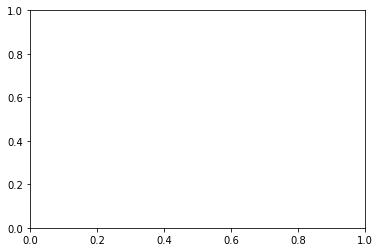

In [56]:
secondary = "fedfunds"
fig,ax = plt.subplots()
ax.plot(data["date"],data["adjclose"])
ax.set_xlabel("date")
ax.set_ylabel("spy")
ax2 = ax.twinx()
ax2.plot(data["date"],data[secondary],color="red")
ax2.set_xlabel("fedfunds")
plt.show()

In [59]:
dataset = []
for year in tqdm(range(2015,2021)):
    for quarter in range(1,5):
        try:
            year_training_data = spy[(spy["year"]==year) & (spy["quarter"]==quarter)]
            print(year_training_data.index.size,year,quarter)
            year_label = spy[(spy["year"]==year+1) & (spy["quarter"]==quarter)]
            var = variance(year_training_data["adjclose"])
            delta = (year_training_data.tail(1)["adjclose"].item() - year_training_data.iloc[0]["adjclose"]) / year_training_data.iloc[0]["adjclose"]
            average_spy = year_training_data["adjclose"].mean()
            average_spy_label = year_label["adjclose"].mean()
            delta_label = (year_label.tail(1)["adjclose"].item() - year_label.iloc[0]["adjclose"]) / year_label.iloc[0]["adjclose"]
            dataset.append({
                "year":year,
                "quarter":quarter,
                "variance":var,
                "delta":delta,
                "spy":average_spy,
                "spy_label":average_spy_label,
                "delta_label":delta_label
            })
        except Exception as e:
            print(year,quarter,str(e))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 113.18it/s]

90 2015 1
91 2015 2
92 2015 3
92 2015 4
91 2016 1
91 2016 2
92 2016 3
92 2016 4
90 2017 1
91 2017 2
92 2017 3
92 2017 4
90 2018 1
91 2018 2
92 2018 3
92 2018 4
90 2019 1
91 2019 2
92 2019 3
92 2019 4
91 2020 1
91 2020 2
2020 2 cannot convert NaN to integer ratio
92 2020 3
92 2020 4
2020 4 cannot convert NaN to integer ratio


In [60]:
practice_set = pd.DataFrame(dataset)

In [61]:
practice_set["classification_label"] = [x > 0 for x in practice_set["delta_label"]]

In [62]:
practice_set

,year,quarter,variance,delta,spy,spy_label,delta_label,classification_label
0,2015,1,7.566281e+02,-0.222833,251.209678,410.728769,-0.040533,False
1,2015,2,9.511506e+01,0.063897,236.858308,512.492754,0.611008,True
2,2015,3,6.159308e+02,-0.087236,254.859673,615.702601,-0.098420,False
3,2015,4,5.133572e+03,0.812540,346.037141,732.721989,0.569658,True
4,2016,1,5.032259e+02,-0.040533,410.728769,1034.707398,0.073588,True
5,2016,2,1.042061e+04,0.611008,512.492754,1912.552198,1.296011,True
6,2016,3,1.330277e+03,-0.098420,615.702601,3482.149449,0.782140,True
7,2016,4,8.101302e+03,0.569658,732.721989,9507.376189,2.214631,True
8,2017,1,1.544317e+04,0.073588,1034.707398,10568.062256,-0.489388,False
9,2017,2,3.768083e+05,1.296011,1912.552198,7766.967677,-0.064321,False


In [73]:
econ_set = data.merge(practice_set[["year","quarter","variance","delta","spy","spy_label","classification_label"]],on=["year","quarter"],how="left")

In [75]:
econ_set = econ_set.groupby(["year","quarter"]).mean().reset_index().dropna()

In [76]:
econ_set

,year,quarter,month,adjclose,fedfunds,gdp,crude,cpi,unemployment,variance,delta,spy,spy_label
2,2015,1,2.032787,251.211607,0.110000,1.823830e+13,48.485246,86.525525,5.529508,7.566281e+02,-0.222833,251.209678,410.728769
3,2015,2,5.015873,236.612143,0.123333,1.823830e+13,57.854603,87.820795,5.428571,9.511506e+01,0.063897,236.858308,512.492754
4,2015,3,7.984375,254.474576,0.136667,1.823830e+13,46.486094,87.914836,5.101562,6.159308e+02,-0.087236,254.859673,615.702601
5,2015,4,11.000000,345.878718,0.160000,1.823830e+13,41.936563,87.537304,5.031250,5.133572e+03,0.812540,346.037141,732.721989
6,2016,1,2.049180,411.049048,0.360000,1.874508e+13,33.351803,87.794140,4.904918,5.032259e+02,-0.040533,410.728769,1034.707398
7,2016,2,5.015625,511.600059,0.373333,1.874508e+13,45.460625,88.960883,4.932812,1.042061e+04,0.611008,512.492754,1912.552198
8,2016,3,8.015625,613.361409,0.396667,1.874508e+13,44.851875,89.120099,4.901562,1.330277e+03,-0.098420,615.702601,3482.149449
9,2016,4,11.000000,731.574682,0.450000,1.874508e+13,49.135556,89.516099,4.766667,8.101302e+03,0.569658,732.721989,9507.376189
10,2017,1,2.048387,1043.383742,0.700000,1.954298e+13,51.621290,90.464311,4.558065,1.544317e+04,0.073588,1034.707398,10568.062256
11,2017,2,5.047619,1939.100632,0.950000,1.954298e+13,48.103810,90.687382,4.365079,3.768083e+05,1.296011,1912.552198,7766.967677


In [85]:
training_set = econ_set[econ_set["year"]<2019].reset_index()
prediction_set = econ_set[econ_set["year"]>=2019].reset_index()
prediction_set["date"] = [datetime(int(row[1]["year"]),int(3*(row[1]["quarter"] - 1)+1),1) for row in prediction_set.iterrows()]
training_set["date"] = [datetime(int(row[1]["year"]),int(3*(row[1]["quarter"] - 1)+1),1) for row in training_set.iterrows()]

In [86]:
training_set

,index,year,quarter,month,adjclose,fedfunds,gdp,crude,cpi,unemployment,variance,delta,spy,spy_label,date
0,2,2015,1,2.032787,251.211607,0.110000,1.823830e+13,48.485246,86.525525,5.529508,7.566281e+02,-0.222833,251.209678,410.728769,2015-01-01
1,3,2015,2,5.015873,236.612143,0.123333,1.823830e+13,57.854603,87.820795,5.428571,9.511506e+01,0.063897,236.858308,512.492754,2015-04-01
2,4,2015,3,7.984375,254.474576,0.136667,1.823830e+13,46.486094,87.914836,5.101562,6.159308e+02,-0.087236,254.859673,615.702601,2015-07-01
3,5,2015,4,11.000000,345.878718,0.160000,1.823830e+13,41.936563,87.537304,5.031250,5.133572e+03,0.812540,346.037141,732.721989,2015-10-01
4,6,2016,1,2.049180,411.049048,0.360000,1.874508e+13,33.351803,87.794140,4.904918,5.032259e+02,-0.040533,410.728769,1034.707398,2016-01-01
5,7,2016,2,5.015625,511.600059,0.373333,1.874508e+13,45.460625,88.960883,4.932812,1.042061e+04,0.611008,512.492754,1912.552198,2016-04-01
6,8,2016,3,8.015625,613.361409,0.396667,1.874508e+13,44.851875,89.120099,4.901562,1.330277e+03,-0.098420,615.702601,3482.149449,2016-07-01
7,9,2016,4,11.000000,731.574682,0.450000,1.874508e+13,49.135556,89.516099,4.766667,8.101302e+03,0.569658,732.721989,9507.376189,2016-10-01
8,10,2017,1,2.048387,1043.383742,0.700000,1.954298e+13,51.621290,90.464311,4.558065,1.544317e+04,0.073588,1034.707398,10568.062256,2017-01-01
9,11,2017,2,5.047619,1939.100632,0.950000,1.954298e+13,48.103810,90.687382,4.365079,3.768083e+05,1.296011,1912.552198,7766.967677,2017-04-01


In [82]:
factors = ["variance","fedfunds","delta","spy","gdp","crude","cpi","unemployment"]

In [83]:
training_set

,year,quarter,month,adjclose,fedfunds,gdp,crude,cpi,unemployment,variance,delta,spy,spy_label,date
2,2015,1,2.032787,251.211607,0.110000,1.823830e+13,48.485246,86.525525,5.529508,7.566281e+02,-0.222833,251.209678,410.728769,2015-01-01
3,2015,2,5.015873,236.612143,0.123333,1.823830e+13,57.854603,87.820795,5.428571,9.511506e+01,0.063897,236.858308,512.492754,2015-04-01
4,2015,3,7.984375,254.474576,0.136667,1.823830e+13,46.486094,87.914836,5.101562,6.159308e+02,-0.087236,254.859673,615.702601,2015-07-01
5,2015,4,11.000000,345.878718,0.160000,1.823830e+13,41.936563,87.537304,5.031250,5.133572e+03,0.812540,346.037141,732.721989,2015-10-01
6,2016,1,2.049180,411.049048,0.360000,1.874508e+13,33.351803,87.794140,4.904918,5.032259e+02,-0.040533,410.728769,1034.707398,2016-01-01
7,2016,2,5.015625,511.600059,0.373333,1.874508e+13,45.460625,88.960883,4.932812,1.042061e+04,0.611008,512.492754,1912.552198,2016-04-01
8,2016,3,8.015625,613.361409,0.396667,1.874508e+13,44.851875,89.120099,4.901562,1.330277e+03,-0.098420,615.702601,3482.149449,2016-07-01
9,2016,4,11.000000,731.574682,0.450000,1.874508e+13,49.135556,89.516099,4.766667,8.101302e+03,0.569658,732.721989,9507.376189,2016-10-01
10,2017,1,2.048387,1043.383742,0.700000,1.954298e+13,51.621290,90.464311,4.558065,1.544317e+04,0.073588,1034.707398,10568.062256,2017-01-01
11,2017,2,5.047619,1939.100632,0.950000,1.954298e+13,48.103810,90.687382,4.365079,3.768083e+05,1.296011,1912.552198,7766.967677,2017-04-01


In [34]:
# delta_model = m.regression({"X":training_set[factors],"y":training_set.rename(columns={"delta_label":"y"})[["y"]]})

In [87]:
spy_model = m.regression({"X":training_set[factors],"y":training_set.rename(columns={"spy_label":"y"})[["y"]]})

In [36]:
#classification_model = m.classification({"X":training_set[factors],"y":training_set.rename(columns={"classification_label":"y_class"})[["y_class"]]},xgb=True,sk=True,multioutput=False)

In [37]:
# classification_model = pd.DataFrame(classification_model)

In [38]:
# class_sim = prediction_set.copy()
# for row in classification_model.iterrows():
#     model = row[1]["model"]
#     api = row[1]["api"]
#     score = row[1]["score"]
#     predictions = model.predict(class_sim[factors])
#     class_sim[f"{api}_prediction"] = predictions
#     class_sim[f"{api}_score"] = score

In [39]:
# classification_model

In [88]:
spy_model

,api,model,score,model_type
0,skl,LinearRegression(),-5.328936,regression
1,xgb,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.746189,regression
2,cat,<catboost.core.CatBoostRegressor object at 0x0...,0.759348,regression


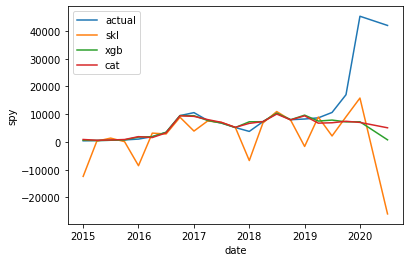

In [89]:
sim = econ_set.copy()
secondary = "cpi"
for row in spy_model.iterrows():
    model = row[1]["model"]
    api = row[1]["api"]
    score = row[1]["score"]
    predictions = model.predict(sim[factors])
    sim[f"{api}_prediction"] = predictions
    sim[f"{api}_score"] = score
fig,ax = plt.subplots()
ax.plot(sim["date"],sim["spy_label"])
for api in ["skl","xgb","cat"]:
    ax.plot(sim["date"],sim[f"{api}_prediction"])
ax.legend(["actual","skl","xgb","cat"])
ax.set_xlabel("date")
ax.set_ylabel("spy")
# ax2 = ax.twinx()
# ax2.plot(sim["date"],sim[secondary],color="purple")
# ax2.set_xlabel(secondary)
plt.show()

In [90]:
data

,year,quarter,month,adjclose,fedfunds,gdp,crude,cpi,unemployment
0,2014,3,9.000000,411.612799,0.090000,1.752716e+13,93.128000,88.114026,5.900000
1,2014,4,10.984375,358.715937,0.100000,1.752716e+13,73.211250,87.229801,5.695312
2,2015,1,2.032787,251.211607,0.110000,1.823830e+13,48.485246,86.525525,5.529508
3,2015,2,5.015873,236.612143,0.123333,1.823830e+13,57.854603,87.820795,5.428571
4,2015,3,7.984375,254.474576,0.136667,1.823830e+13,46.486094,87.914836,5.101562
5,2015,4,11.000000,345.878718,0.160000,1.823830e+13,41.936563,87.537304,5.031250
6,2016,1,2.049180,411.049048,0.360000,1.874508e+13,33.351803,87.794140,4.904918
7,2016,2,5.015625,511.600059,0.373333,1.874508e+13,45.460625,88.960883,4.932812
8,2016,3,8.015625,613.361409,0.396667,1.874508e+13,44.851875,89.120099,4.901562
9,2016,4,11.000000,731.574682,0.450000,1.874508e+13,49.135556,89.516099,4.766667


In [91]:
dataset = []
for year in tqdm(range(2000,2023)):
    for quarter in range(1,5):
        try:
            year_training_data = spy[(spy["year"]==year) & (spy["quarter"]==quarter)]
            var = variance(year_training_data["adjclose"])
            delta = (year_training_data.tail(1)["adjclose"].item() - year_training_data.iloc[0]["adjclose"]) / year_training_data.iloc[0]["adjclose"]
            average_spy = year_training_data["adjclose"].mean()
            dataset.append({
                "year":year,
                "quarter":quarter,
                "variance":var,
                "delta":delta,
                "spy":average_spy,
            })
        except Exception as e:
            print(year,quarter,str(e))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 328.50it/s]

2000 1 variance requires at least two data points
2000 2 variance requires at least two data points
2000 3 variance requires at least two data points
2000 4 variance requires at least two data points
2001 1 variance requires at least two data points
2001 2 variance requires at least two data points
2001 3 variance requires at least two data points
2001 4 variance requires at least two data points
2002 1 variance requires at least two data points
2002 2 variance requires at least two data points
2002 3 variance requires at least two data points
2002 4 variance requires at least two data points
2003 1 variance requires at least two data points
2003 2 variance requires at least two data points
2003 3 variance requires at least two data points
2003 4 variance requires at least two data points
2004 1 variance requires at least two data points
2004 2 variance requires at least two data points
2004 3 variance requires at least two data points
2004 4 variance requires at least two data points


In [98]:
forward_set = pd.DataFrame(dataset)
forward_data = data.merge(forward_set,on=["year","quarter"]).groupby(["year","quarter"]).mean().reset_index()

In [99]:
spy_model

,api,model,score,model_type
0,skl,LinearRegression(),-5.328936,regression
1,xgb,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.746189,regression
2,cat,<catboost.core.CatBoostRegressor object at 0x0...,0.759348,regression


In [102]:
sim = forward_data[forward_data["year"]>2020].copy()
sim["date"] = [datetime(int(row[1]["year"]) +1,int(3*(row[1]["quarter"] - 1)+1),1) for row in sim.iterrows()]
secondary = "cpi"
for row in spy_model.iterrows():
    model = row[1]["model"]
    api = row[1]["api"]
    score = row[1]["score"]
    predictions = model.predict(sim[factors])
    sim[f"{api}_prediction"] = predictions
    sim[f"{api}_score"] = score
fig,ax = plt.subplots()
for api in ["skl","xgb","cat"]:
    ax.plot(sim["date"],sim[f"{api}_prediction"])
ax.legend(["skl","xgb","cat","light"])
ax.set_xlabel("date")
ax.set_ylabel("spy")
# ax2 = ax.twinx()
# ax2.plot(sim["date"],sim[secondary],color="purple")
# ax2.set_xlabel(secondary)
plt.show()

ValueError: Found array with 0 sample(s) (shape=(0, 8)) while a minimum of 1 is required.

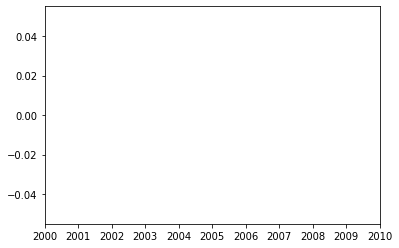

In [101]:
spy_viz = spy[spy["date"]>datetime(2021,12,1)]
plt.plot(spy_viz["date"],spy_viz["adjclose"])

In [ ]:
spy_viz

In [ ]:
sim[sim["date"]>datetime(2021,12,1)][["date","skl_prediction","xgb_prediction","cat_prediction","light_prediction"]]

In [ ]:
# import pickle 
# market.connect()
# spy_model["model"] = [pickle.dumps(x) for x in spy_model["model"]]
# market.store("econ_models",spy_model)
# market.disconnect()